## XGB EVI Trend Break Magnitude Models - v2

Peter R., 2023-09-11

### Intro
I used DRAC server (Cedar) to run a few Extreme Gradient Boosting (XGB) models with Python. I used XGBRegression() to analyze forest EVI breaks (all breaks together, only negative & only positive breaks). The response variable was EVI tren break magnitudes and the predictors were around a dozen forest and climate variables.

Here I try to answer the question: What factors predict EVI Trend Break magnitude? 

Note that driver data was assigned via spatio-temporal matches between breaks and remote sensing derived disturbance data. So far, I only have data for three drivers: fire, harvest, & insects.  The driver data are mainly nulls as I was not able to match most of the EVI breaks with disturbance data. Hence, I have left out these variables. An important missing driver is likely tree windthrow (see Somerfield et al. 2018). I also left out percent conifer as well mositure variables given the  high correlation between these and percent deciduous and precipitation.

Here I manily explore and create visualizations of the models created with DRAC.

#### Positive breaks XGB model

Here I run positive breaks only.

In [1]:
import os
import time

import pandas as pd
from numpy import nan
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Get the current working directory
cwd = os.getcwd()

print(cwd)

# DRAC directory
#os.chdir("/home/georod/projects/def-mfortin/georod/scripts/github/forc_trends/models/xgboost")


# Load model
# load saved model
model_bp1 = xgb.XGBRegressor()
model_bp1.load_model("model_bp1_pos_brks_v2.json")


C:\Users\Peter R\github\forc_trends\models\xgboost


In [2]:
# Windows
df1 = pd.read_csv(r'.\data\forest_evi_breaks_positive_v1.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v1.csv', skipinitialspace=True)
#df1.head()

df2 = pd.get_dummies(df1, columns=['protected'], dtype=float)

df2= df2[df2['precipitation'].notna()]

X1 = df2.iloc[:,2:30]

X1.drop(X1.columns[[2, 12, 14, 16, 18, 19, 20,21,22,23,24,25]], axis=1,inplace=True)

y1 = df2.iloc[:,1]


#features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3",
 #                "rh" ,"rh_lag1","rh_lag2","rh_lag3"]

seed = 7 # random seed to help with replication
testsize1 = 0.33 # percent of records to test after training

# Split data set. Note the 'stratify' option
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed)

#print(df2.describe)

In [3]:
#EVALUATION (with train and CV)

# pos bp1
#Mean MAE: 220.499 (13.534)
#Mean MSE: 220.499 (13.534)
#Mean RMSE: 14.849 (3.679)
#Mean Var. Explained: 0.310 (0.070)
#R-sq: 0.305 (0.070)
#MSE: 105226.33
#RMSE: 324.39
#R-sq: 0.33
#Total time: 3756.35


# EVALUATION (with test)
#eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
#UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
#model_bp1.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
# make predictions for test data
#y_pred = model_bp1.predict(x1_test)
#predictions = [round(value) for value in y_pred]
# retrieve performance metrics
#results = model_bp1.evals_result()

#mse = mean_squared_error(y1_test, y_pred)
#r2 = explained_variance_score(y1_test, ypred)
#r2 = r2_score(y1_test, y_pred)
#print("MSE: %.2f" % mse)

#print("RMSE: %.2f" % (mse**(1/2.0)))

#print("R-sq: %.2f" % r2)

In [3]:
# Best parameters 2nd model

# Load model
# load saved model
model_bp2 = xgb.XGBRegressor()
model_bp2.load_model("model_bp2_pos_brks_v2.json")
#model_bp2
#model_bp2.best_score
#model_bp2.best_iteration (this is not number of trees)



In [4]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# EVALUATION (with test)
eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
#UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = model_bp2.predict(x1_test)
predictions = [round(value) for value in y_pred]
# retrieve performance metrics
results = model_bp2.evals_result()

#epochs = len(results['validation_0']['error'])
#x_axis = range(0, epochs)


mse = mean_squared_error(y1_test, y_pred)
#r2 = explained_variance_score(y1_test, ypred)
r2 = r2_score(y1_test, y_pred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

print("R-sq: %.2f" % r2)

#model_bp1
#MSE: 108697.93
#RMSE: 329.69
#R-sq: 0.31


MSE: 102081.95
RMSE: 319.50
R-sq: 0.35


NameError: name 'x_axis' is not defined

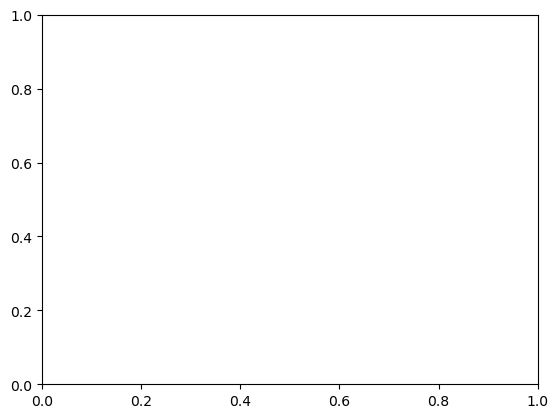

In [5]:
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
#pyplot.axvline(2341, color="gray", label="Optimal tree number")
pyplot.xlabel("Number of trees")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.show()
# This plot tells me I should run another model limiting the number of trees

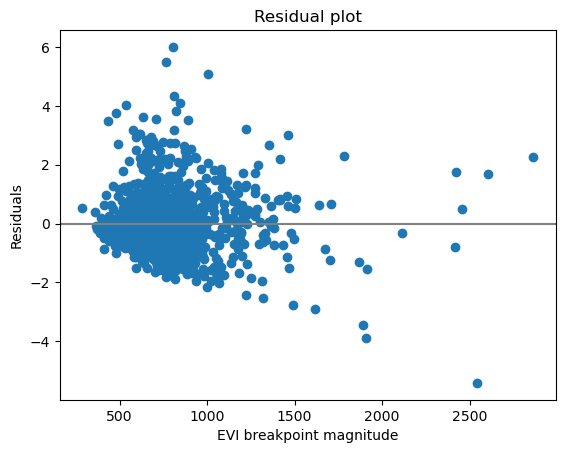

In [6]:
# Model prediction residuals

residuals = y1_test-y_pred

mean = residuals.mean()
std = residuals.std()

std_residuals = (residuals - mean)/std


pyplot.scatter(y_pred, std_residuals)

pyplot.ylabel('Residuals')
pyplot.xlabel("EVI breakpoint magnitude")
pyplot.title('Residual plot')
pyplot.axhline(0, color="gray")

pyplot.show()

In [8]:
# Feature importance plot
#xgb.plot_importance(model_bp1, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, weight', 
#                    xlabel='F score - weight', ylabel='Features', 
#                    importance_type='weight', max_num_features=10, grid=True, show_values=True)

#plt.savefig('weight.png',  dpi=300, bbox_inches='tight')

#pyplot.show()

#‘weight’: the number of times a feature is used to split the data across all trees.
# weight: is the percentage representing the relative number of times a particular feature occurs in the trees of the model
# less indicative of the predictive contribution of a feature for the whole model.
# binary feature score low with weight but high with gain and coverage

#‘gain’: the average gain across all splits the feature is used in.
# gain: Gain' is the improvement in accuracy brought by a feature to the branches it is on. Higher value the more important
# The Gain is the most relevant attribute to interpret the relative importance of each feature.
# ‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on. 

#‘cover’: the average coverage across all splits the feature is used in.
# cover: The Coverage metric means the relative number of observations related to this feature. Observation-level scope

#‘total_gain’: the total gain across all splits the feature is used in.

#‘total_cover’: the total coverage across all splits the feature is used in.

# F score: This is a metric that simply sums up how many times each feature is split on

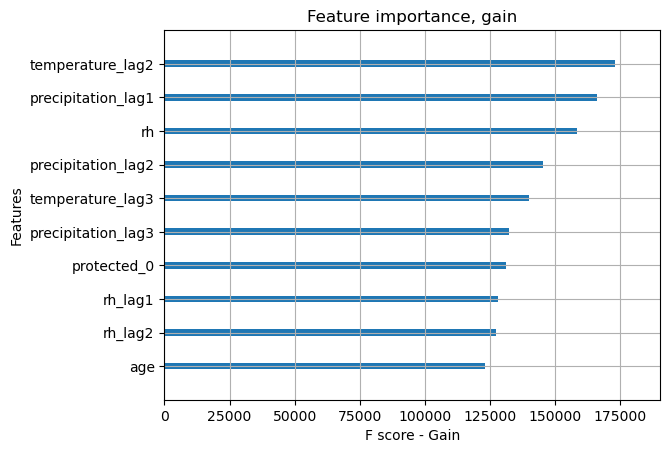

In [7]:
# Plot, metric: gain
#‘gain’: the average gain across all splits the feature is used in.
xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                    xlabel='F score - Gain', ylabel='Features', 
                    importance_type='gain', max_num_features=10, grid=True, show_values=False) #, values_format='{v:.2f}' )

pyplot.savefig(r'.\figs\pos_gain7.png',  dpi=300, bbox_inches='tight')


pyplot.show()

In [10]:
# Plot, metric: total gain
#‘total_gain’: the total gain across all splits the feature is used in.
#xgb.plot_importance(model_bp1, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, Total gain', 
#                    xlabel='F score - Total gain', ylabel='Features', 
#                    importance_type='total_gain', max_num_features=10, grid=True, show_values=False)

#pyplot.savefig('total_gain6.png',  dpi=300, bbox_inches='tight')

#pyplot.show()

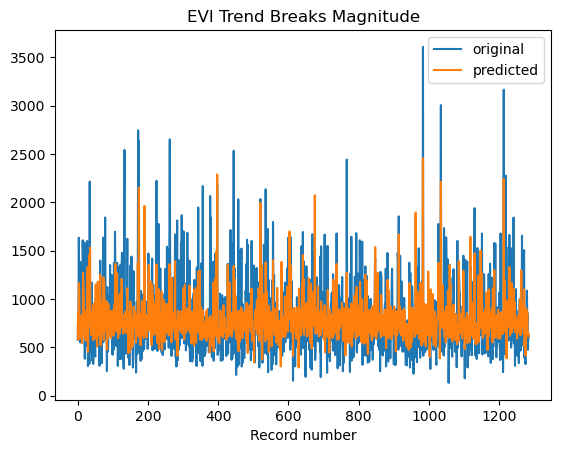

In [11]:
#import matplotlib.pyplot as plt

x_ax = range(len(y1_test))
pyplot.plot(x_ax, y1_test, label="original")
pyplot.plot(x_ax, y_pred, label="predicted")

pyplot.xlabel("Record number") # Order of observations/records in vector

pyplot.title("EVI Trend Breaks Magnitude")

pyplot.legend()

#plt.savefig('original_vs_predicted6.png',  dpi=300, bbox_inches='tight')


pyplot.savefig(r'.\figs\pos_predicted6.png',  dpi=300, bbox_inches='tight')

pyplot.show()

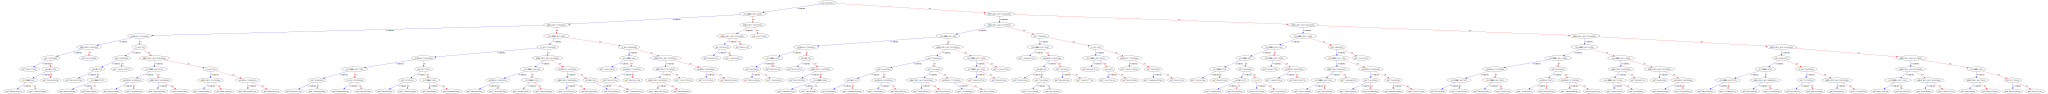

In [14]:
# Plot tree. Use rankdir='LR' to make the plot show sideways
import graphviz

#fig, ax = pyplot.subplots(figsize=(8, 6)) #plt.figure(2, figsize=(8, 6))

#xgb.to_graphviz(model_bp2, num_trees = model_bp2.best_iteration) #num_trees = model_m2e.best_iteration

format = 'png' #You should try the 'svg'

image = xgb.to_graphviz(model_bp2, num_trees = model_bp2.best_iteration) # best_iteration only works with early_stop_rounds

image

#Set a different dpi (works only if format == 'png')
image.graph_attr = {'dpi':'300'}

image.render(r'.\figs\pos_decision_tree6.png', format = format)

image

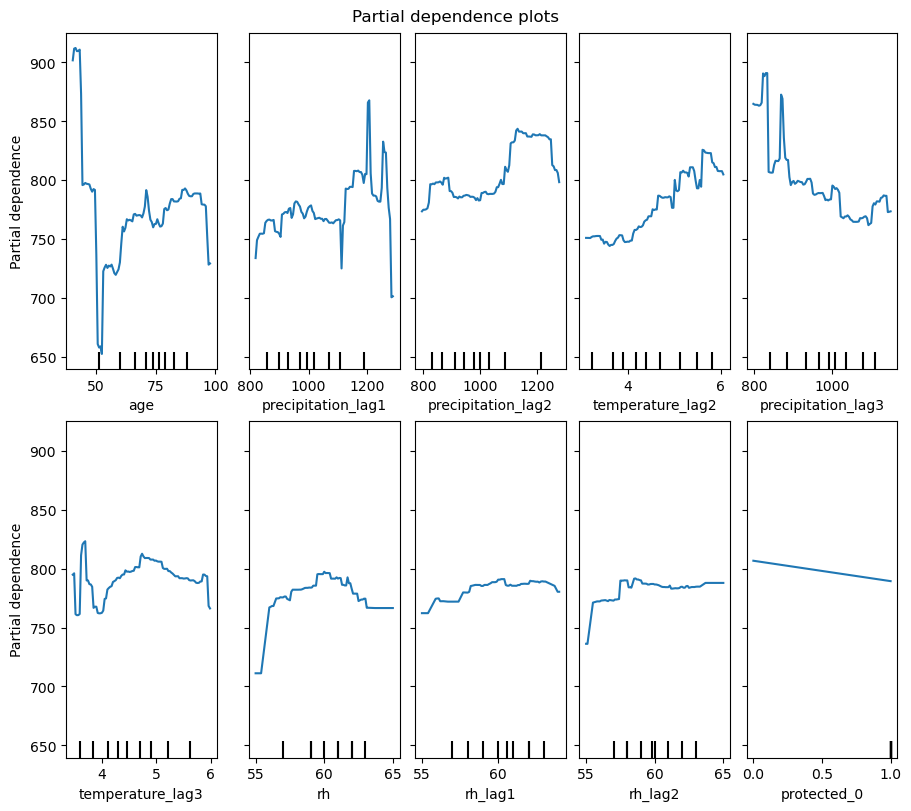

In [9]:
# Partial dependence plots

import matplotlib.pyplot as plt

# PDP is an average of the marginal effects of the features. We are averaging the response of all samples of the provided set.
from sklearn.inspection import PartialDependenceDisplay

#["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3",
#                 "rh" ,"rh_lag1","rh_lag2","rh_lag3"]

features_names2 = ["age","precipitation_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3", "rh", "rh_lag1", "rh_lag2", "protected_0"]
#target_names1 = "Magnitude"

_, ax1 = plt.subplots(ncols=5, nrows=2, figsize=(9, 8), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

_ = display.figure_.suptitle(
    (
        "Partial dependence plots"
        
    ),
    fontsize=12,
)


plt.savefig(r'.\figs\pos_partial_dependence7.png',  dpi=300, bbox_inches='tight')

plt.show()

# Black ticks on X-axis are deciles

#### Negative breaks XGB model

Here I run a model with negative breaks only

In [22]:
import os
import time

import pandas as pd
from numpy import nan
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Get the current working directory
cwd = os.getcwd()

print(cwd)

# DRAC directory
#os.chdir("/home/georod/projects/def-mfortin/georod/scripts/github/forc_trends/models/xgboost")


# Load model
# load saved model
model_bp1 = xgb.XGBRegressor()
model_bp1.load_model("model_bp1_neg_brks_v2.json")

C:\Users\Peter R\github\forc_trends\models\xgboost


In [23]:
# Windows
df1 = pd.read_csv(r'.\data\forest_evi_breaks_negative_v1.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v1.csv', skipinitialspace=True)
#df1.head()

df2 = pd.get_dummies(df1, columns=['protected'], dtype=float)

df2= df2[df2['precipitation'].notna()]

X1 = df2.iloc[:,2:30]

X1.drop(X1.columns[[2, 12, 14, 16, 18, 19, 20,21,22,23,24,25]], axis=1,inplace=True)

y1 = df2.iloc[:,1]


#features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3",
#                 "rh" ,"rh_lag1","rh_lag2","rh_lag3"]

seed = 7 # random seed to help with replication
testsize1 = 0.33 # percent of records to test after training

# Split data set. Note the 'stratify' option
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed)

In [24]:
#EVALUATION (with train and CV)
#neg
#Mean MAE: 202.595 (6.349)
#Mean MSE: 202.595 (6.349)
#Mean Var. Explained: 0.360 (0.057)
#R-sq: 0.359 (0.057)
#MSE: 82562.94
#RMSE: 287.34
#R-sq: 0.36
#Total time: 4665.40
print(X1.describe)

<bound method NDFrame.describe of          age  deciduous  elevation  precipitation  temperature  \
0      36.00     70.205        279          792.0         3.26   
1      84.24     11.997        366          828.0         3.00   
2      75.48     58.422        217          755.0         3.90   
3      55.12     40.139        294          790.0         3.25   
4      60.64     57.045        300          791.0         3.24   
...      ...        ...        ...            ...          ...   
11866  82.86     64.544        371         1052.0         6.58   
11867  85.20     73.386        367         1043.0         6.54   
11868  77.52     85.161        386         1052.0         6.57   
11869  81.66     67.388        330         1042.0         6.82   
11870  87.08     83.085        474         1100.0         6.09   

       precipitation_lag1  temperature_lag1  precipitation_lag2  \
0                     941              3.31                 824   
1                     970              

In [25]:
# Best parameters 2nd model

# Load model
# load saved model
model_bp2 = xgb.XGBRegressor()
model_bp2.load_model("model_bp2_neg_brks_v2.json")
#model_bp2
#model_bp2.best_score
model_bp2.best_iteration #(this is not number of trees)

751

In [26]:
from matplotlib import pyplot

# EVALUATION (with test)
eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
#UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = model_bp2.predict(x1_test)
predictions = [round(value) for value in y_pred]
# retrieve performance metrics
results = model_bp2.evals_result()

#epochs = len(results['validation_0']['error'])
#x_axis = range(0, epochs)


mse = mean_squared_error(y1_test, y_pred)
#r2 = explained_variance_score(y1_test, ypred)
r2 = r2_score(y1_test, y_pred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

print("R-sq: %.2f" % r2)

#MSE: 82239.75
#RMSE: 286.77
#R-sq: 0.36



XGBoostError: [14:58:55] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\data\data.cc:592: Check failed: size == this->num_col_ (23 vs. 16) : Length of feature_type must be equal to number of columns.

NameError: name 'x_axis' is not defined

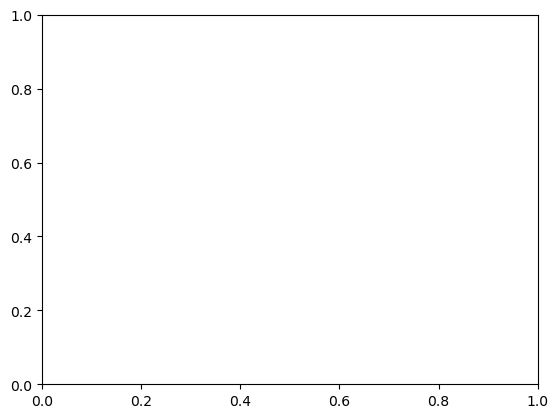

In [21]:
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
pyplot.axvline(100, color="gray", label="Optimal tree number")
pyplot.xlabel("Number of trees")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.show()
# This plot tells me I should run another model limiting the number of trees

In [14]:
# Model prediction residuals

residuals = y1_test-y_pred

mean = residuals.mean()
std = residuals.std()

std_residuals = (residuals - mean)/std


pyplot.scatter(y_pred, std_residuals)

pyplot.ylabel('Residuals')
pyplot.xlabel("EVI breakpoint magnitude")
pyplot.title('Residual plot')
pyplot.axhline(0, color="gray")

pyplot.show()

ValueError: operands could not be broadcast together with shapes (3918,) (1285,) 

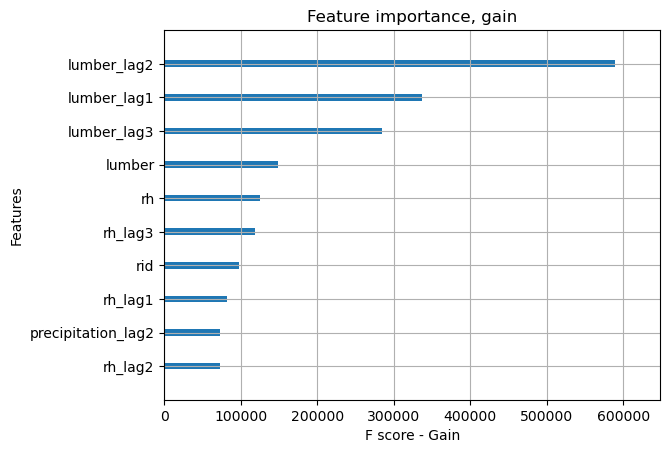

In [21]:
# Plot, metric: gain
#‘gain’: the average gain across all splits the feature is used in.
xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                    xlabel='F score - Gain', ylabel='Features', 
                    importance_type='gain', max_num_features=10, grid=True, show_values=False) #, values_format='{v:.2f}' )

pyplot.savefig(r'.\figs\neg_gain7.png',  dpi=300, bbox_inches='tight')


pyplot.show()

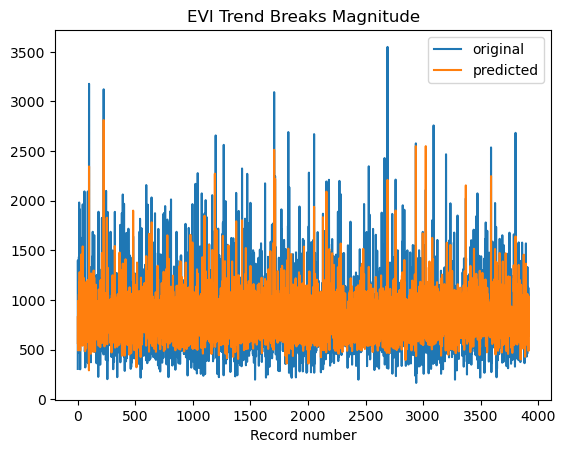

In [25]:
#import matplotlib.pyplot as plt

x_ax = range(len(y1_test))
pyplot.plot(x_ax, y1_test, label="original")
pyplot.plot(x_ax, y_pred, label="predicted")

pyplot.xlabel("Record number") # Order of observations/records in vector

pyplot.title("EVI Trend Breaks Magnitude")

pyplot.legend()

pyplot.savefig(r'.\figs\neg_predicted6.png',  dpi=300, bbox_inches='tight')

pyplot.show()

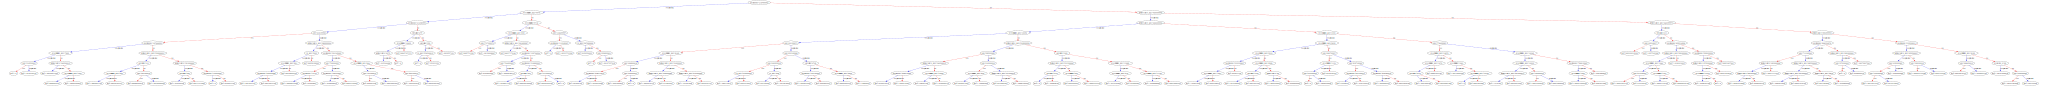

In [26]:
# Plot tree. Use rankdir='LR' to make the plot show sideways
import graphviz

#fig, ax = pyplot.subplots(figsize=(8, 6)) #plt.figure(2, figsize=(8, 6))

#xgb.to_graphviz(model_bp2, num_trees = model_bp2.best_iteration) #num_trees = model_m2e.best_iteration

format = 'png' #You should try the 'svg'

image = xgb.to_graphviz(model_bp2, num_trees = model_bp2.best_iteration) # best_iteration only works with early_stop_rounds

#image

#Set a different dpi (works only if format == 'png')
image.graph_attr = {'dpi':'300'}

image.render(r'.\figs\neg_decision_tree6.png', format = format)

image

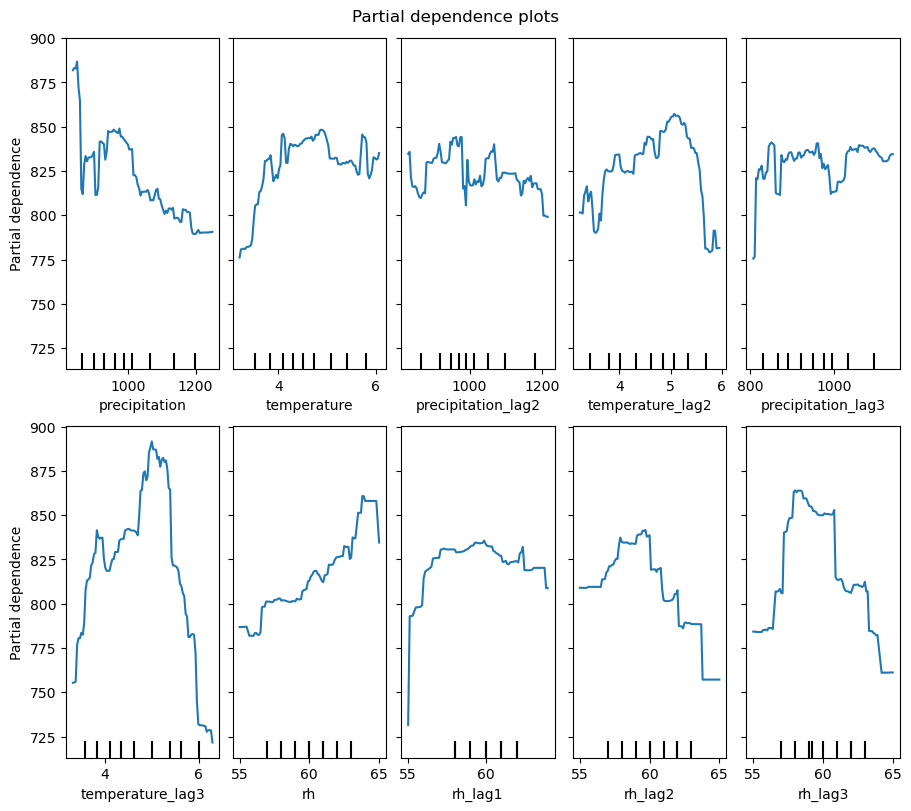

In [27]:
# Partial dependence plots

import matplotlib.pyplot as plt

# PDP is an average of the marginal effects of the features. We are averaging the response of all samples of the provided set.
from sklearn.inspection import PartialDependenceDisplay

#["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3",
#                 "rh" ,"rh_lag1","rh_lag2","rh_lag3"]

features_names2 = ["precipitation", "temperature", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3", "rh", "rh_lag1", "rh_lag2", "rh_lag3"]
#target_names1 = "Magnitude"

_, ax1 = plt.subplots(ncols=5, nrows=2, figsize=(9, 8), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

_ = display.figure_.suptitle(
    (
        "Partial dependence plots"
        
    ),
    fontsize=12,
)


plt.savefig(r'.\figs\neg_partial_dependence6.png',  dpi=300, bbox_inches='tight')

plt.show()

# Black ticks on X-axis are deciles

#### All breaks (negative & positive) XGB model

In [28]:
import os
import time

import pandas as pd
from numpy import nan
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Get the current working directory
cwd = os.getcwd()

print(cwd)

# DRAC directory
#os.chdir("/home/georod/projects/def-mfortin/georod/scripts/github/forc_trends/models/xgboost")


# Load model
# load saved model
model_bp1 = xgb.XGBRegressor()
model_bp1.load_model("model_bp1_all_brks_v1.json")

C:\Users\Peter R\github\forc_trends\models\xgboost


In [29]:
# Windows
df1 = pd.read_csv(r'.\data\forest_evi_breaks_v1.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v1.csv', skipinitialspace=True)
#df1.head()

df2 = pd.get_dummies(df1, columns=['protected'], dtype=float)

df2= df2[df2['precipitation'].notna()]

X1 = df2.iloc[:,2:24]

X1.drop(X1.columns[[2, 12, 14, 16, 18]], axis=1,inplace=True)

y1 = df2.iloc[:,1]


features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3",
                 "rh" ,"rh_lag1","rh_lag2","rh_lag3"]

seed = 7 # random seed to help with replication
testsize1 = 0.33 # percent of records to test after training

# Split data set. Note the 'stratify' option
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed)

In [30]:
# Best parameters 2nd model

# Load model
# load saved model
model_bp2 = xgb.XGBRegressor()
model_bp2.load_model("model_bp2_all_brks_v1.json")
#model_bp2
#model_bp2.best_score
model_bp2.best_iteration #(this is not number of trees)

559

In [32]:
#EVALUATION (with train and CV)
# all breaks
#Mean MAE: 370.861 (11.770)
#Mean MSE: 370.861 (11.770)
#Mean Var. Explained: 0.487 (0.025)
#R-sq: 0.486 (0.025)

#MSE: 318120.82
#RMSE: 564.02
#R-sq: 0.50
#Total time: 6682.17


from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# EVALUATION (with test)
eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
#UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = model_bp2.predict(x1_test)
predictions = [round(value) for value in y_pred]
# retrieve performance metrics
results = model_bp2.evals_result()

#epochs = len(results['validation_0']['error'])
#x_axis = range(0, epochs)


mse = mean_squared_error(y1_test, y_pred)
#r2 = explained_variance_score(y1_test, ypred)
r2 = r2_score(y1_test, y_pred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

print("R-sq: %.2f" % r2)

MSE: 316580.11
RMSE: 562.65
R-sq: 0.50


NameError: name 'x_axis' is not defined

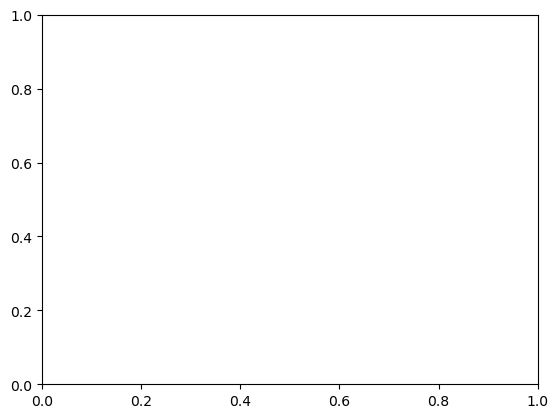

In [33]:
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
#pyplot.axvline(2341, color="gray", label="Optimal tree number")
pyplot.xlabel("Number of trees")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.show()
# This plot tells me I should run another model limiting the number of trees

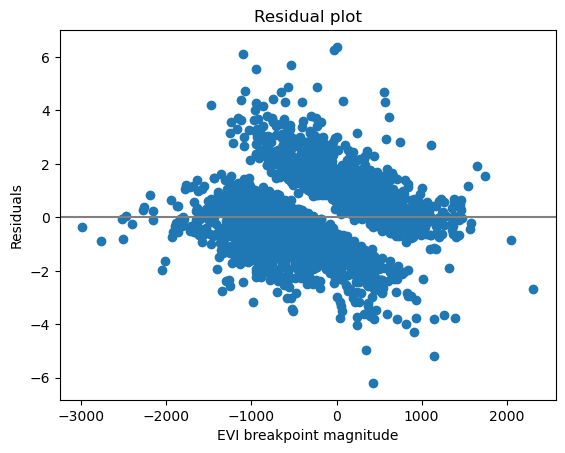

In [34]:
# Model prediction residuals

residuals = y1_test-y_pred

mean = residuals.mean()
std = residuals.std()

std_residuals = (residuals - mean)/std


pyplot.scatter(y_pred, std_residuals)

pyplot.ylabel('Residuals')
pyplot.xlabel("EVI breakpoint magnitude")
pyplot.title('Residual plot')
pyplot.axhline(0, color="gray")

pyplot.show()


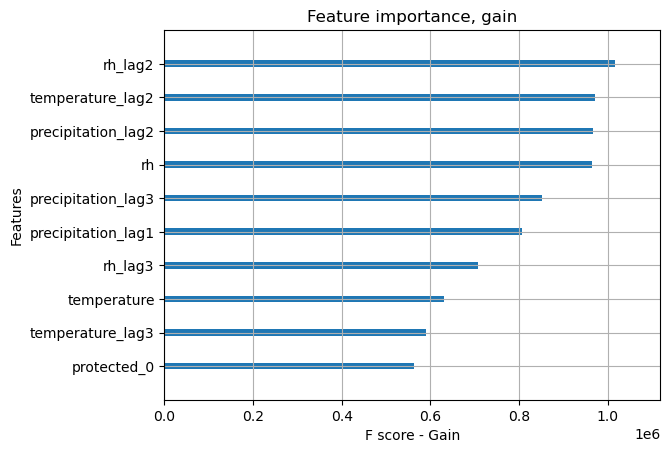

In [35]:
# Plot, metric: gain
#‘gain’: the average gain across all splits the feature is used in.
xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                    xlabel='F score - Gain', ylabel='Features', 
                    importance_type='gain', max_num_features=10, grid=True, show_values=False) #, values_format='{v:.2f}' )

pyplot.savefig(r'.\figs\all_gain6.png',  dpi=300, bbox_inches='tight')


pyplot.show()

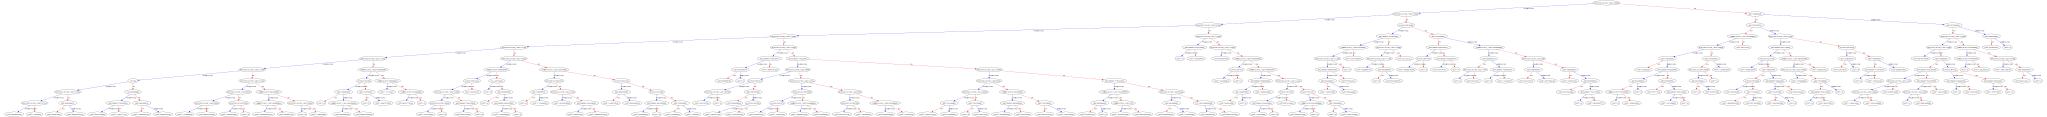

In [36]:
# Plot tree. Use rankdir='LR' to make the plot show sideways
import graphviz

#fig, ax = pyplot.subplots(figsize=(8, 6)) #plt.figure(2, figsize=(8, 6))

#xgb.to_graphviz(model_bp2, num_trees = model_bp2.best_iteration) #num_trees = model_m2e.best_iteration

format = 'png' #You should try the 'svg'

image = xgb.to_graphviz(model_bp2, num_trees = model_bp2.best_iteration) # best_iteration only works with early_stop_rounds

#image

#Set a different dpi (works only if format == 'png')
image.graph_attr = {'dpi':'300'}

image.render(r'.\figs\all_decision_tree6.png', format = format)

image


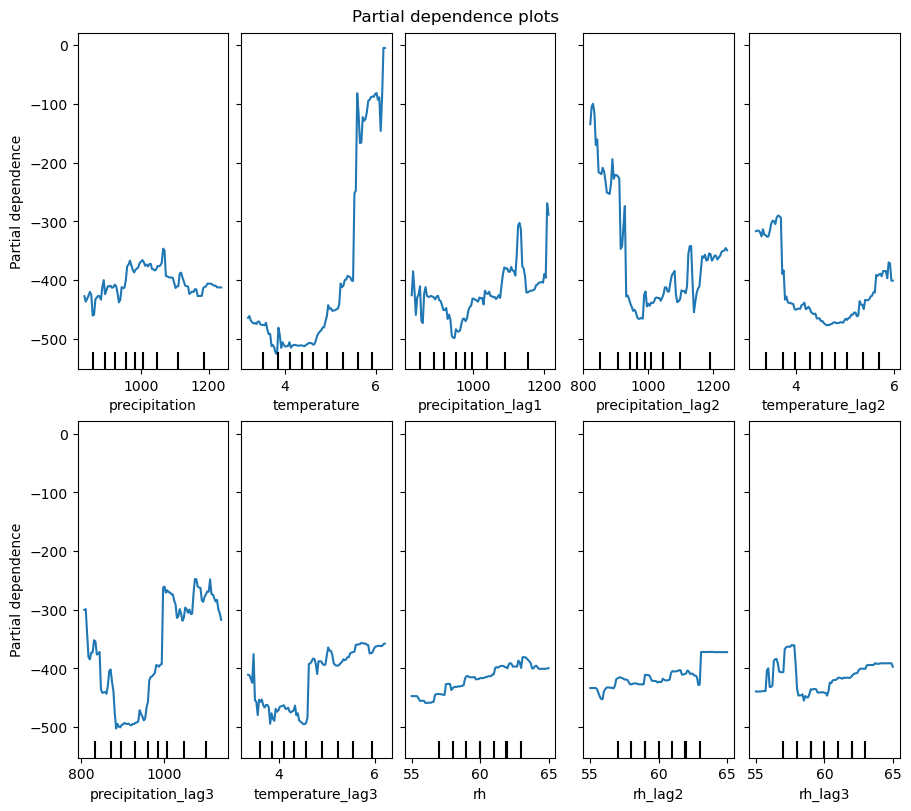

In [37]:
# Partial dependence plots

import matplotlib.pyplot as plt

# PDP is an average of the marginal effects of the features. We are averaging the response of all samples of the provided set.
from sklearn.inspection import PartialDependenceDisplay

#["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3",
#                 "rh" ,"rh_lag1","rh_lag2","rh_lag3"]

features_names2 = ["precipitation","temperature","precipitation_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3", "rh", "rh_lag2", "rh_lag3"]
#target_names1 = "Magnitude"

_, ax1 = plt.subplots(ncols=5, nrows=2, figsize=(9, 8), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

_ = display.figure_.suptitle(
    (
        "Partial dependence plots"
        
    ),
    fontsize=12,
)


plt.savefig(r'.\figs\all_partial_dependence6.png',  dpi=300, bbox_inches='tight')

plt.show()

# Black ticks on X-axis are deciles

C:\Users\Peter R\anaconda3\envs\xgboost1\lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


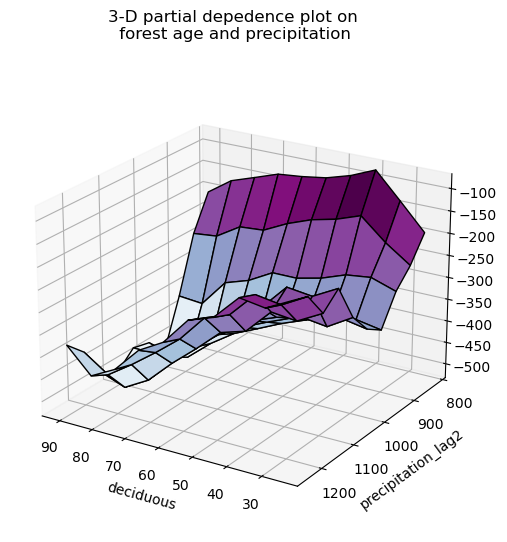

In [41]:
# 3D plot
import mpl_toolkits.mplot3d  # noqa: F401
import numpy as np

from sklearn.inspection import partial_dependence

fig = plt.figure(figsize=(6.5,6))

features = ("deciduous", "precipitation_lag2")

pdp = partial_dependence(
    model_bp2,
    x1_train, features=features, kind="average", grid_resolution=10
)

XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1]) #"grid_values" in newer version of sklearn
Z = pdp.average[0].T
ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
fig.suptitle(
    "3-D partial depedence plot on\n forest age and precipitation",
    fontsize=12,
)
# pretty init view
ax.view_init(elev=22, azim=122)
#clb = plt.colorbar(surf, pad=0.08, shrink=0.6, aspect=10)
#clb.ax.set_title("Partial\ndependence")

plt.savefig(r'.\figs\all_3d_partial_dependence6.png',  dpi=300, bbox_inches='tight')

plt.show()

#### References

Mostly tutorials & blogs.

https://www.youtube.com/watch?v=OQKQHNCVf5k

https://www.youtube.com/watch?v=GrJP9FLV3FE&t=2167s

https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost

https://mljar.com/blog/xgboost-save-load-python/

https://machinelearningmastery.com/xgboost-for-regression/

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html

https://github.com/parrt/dtreeviz

https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost

https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

https://scikit-learn.org/stable/modules/partial_dependence.html

https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#way-partial-dependence-with-different-models

https://mljar.com/blog/xgboost-early-stopping/

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

https://github.com/parrt/dtreeviz



